# Demonstration of MUSE

This is a demonstration of MUSE analysis on a multi-modality simulated data.

Altschuler & Wu Lab 2020.

Software provided as is under MIT License.

## Import packages

In [1]:
import muse_sc as muse
import simulation_tool.multi_modal_simulation as simulation
import phenograph
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mofapy2.run.entry_point import entry_point
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

np.random.seed(0)

## Generate simulation data

Simulation parameters

In [2]:
latent_dim = 100
num_cluster = 10
sample_size = 1000
latent_code_dim = 30
observed_data_dim = 500
sigma_1 = 0.1  
sigma_2 = 0.1  
decay_coef_1 = 0.5 
decay_coef_2 = 0.1
merge_prob = 0.7

Use simulation tool to generate multi-modality data

In [3]:
data = simulation.multi_modal_simulator(num_cluster, sample_size,
                                        observed_data_dim, observed_data_dim,
                                        latent_code_dim,
                                        sigma_1, sigma_2,
                                        decay_coef_1, decay_coef_2,
                                        merge_prob)
data_a = data['data_a_dropout']
data_b = data['data_b_dropout']
label_a = data['data_a_label']
label_b = data['data_b_label']
label_true = data['true_cluster']

## Analyses based on single modality-alone

Learn features from single modality

In [4]:
view_a_feature = PCA(n_components=latent_dim).fit_transform(data_a)
view_b_feature = PCA(n_components=latent_dim).fit_transform(data_b)

Perform clustering using PhenoGraph

In [5]:
view_a_label, _, _ = phenograph.cluster(view_a_feature)
view_b_label, _, _ = phenograph.cluster(view_b_feature)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.15044188499450684 seconds
Jaccard graph constructed in 0.6791424751281738 seconds
Wrote graph to binary file in 0.20223593711853027 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.445095
Louvain completed 21 runs in 0.7541890144348145 seconds
PhenoGraph complete in 1.8222253322601318 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.12529778480529785 seconds
Jaccard graph constructed in 0.731212854385376 seconds
Wrote graph to binary file in 0.09008526802062988 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.716063
Louvain completed 21 runs in 0.7840828895568848 seconds
PhenoGraph complete in 1.7428393363952637 seconds


## Combined analysis using MUSE

MUSE learns the joint latent representation

In [6]:
muce_feature, reconstruct_x, reconstruct_y, \
latent_x, latent_y = muse.muse_fit_predict(data_a,
                                           data_b,
                                           label_a,
                                           label_b,
                                           latent_dim=100,
                                           n_epochs=500,
                                           lambda_regul=5,
                                           lambda_super=5)

MUSE initialization
epoch: 0, 	 total loss: 1920.69824,	 reconstruction loss: 920.46063,	 sparse penalty: 200.04752
epoch: 50, 	 total loss: 1099.50452,	 reconstruction loss: 154.93652,	 sparse penalty: 188.91360
epoch: 0, 	 total loss: 1088.51123,	 reconstruction loss: 154.95114,	 sparse penalty: 177.71677,	 x triplet: 4.42918,	 y triplet: 4.56606
epoch: 50, 	 total loss: 993.03607,	 reconstruction loss: 154.95154,	 sparse penalty: 166.87881,	 x triplet: 0.43126,	 y triplet: 0.30684
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.22858691215515137 seconds
Jaccard graph constructed in 2.69346022605896 seconds
Wrote graph to binary file in 0.07274818420410156 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.843777
Louvain completed 21 runs in 1.742429494857788 seconds
PhenoGraph complete in 4.747075796127319 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors 

PhenoGraph clustering

In [7]:
muce_label, _, _ = phenograph.cluster(muce_feature)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.13152861595153809 seconds
Jaccard graph constructed in 2.0573768615722656 seconds
Wrote graph to binary file in 0.10533475875854492 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.899295
Louvain completed 21 runs in 1.668703556060791 seconds
PhenoGraph complete in 3.984872817993164 seconds


## Visualization of latent spaces 
Latent spaces of single-modality features or MUSE features were visualized using tSNE, with ground truth cluster labels.

Cluster accuries were quantified using adjusted Rand index (ARI). ARI = 1 indicates perfectly discover true cell identities.

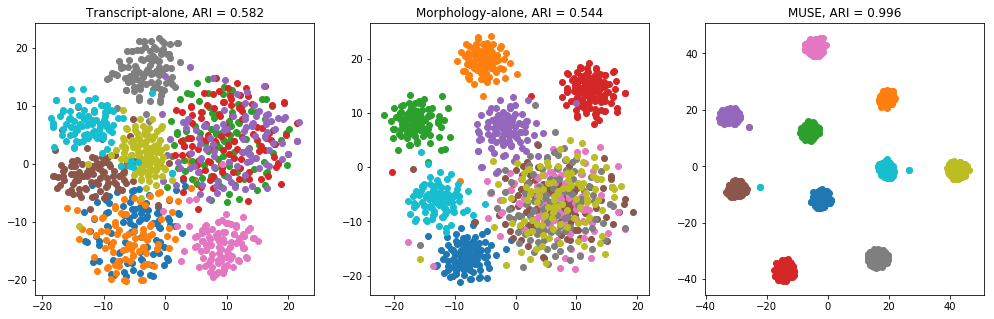

In [8]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
X_embedded = TSNE(n_components=2).fit_transform(view_a_feature)
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('Transcript-alone, ARI = %01.3f' % adjusted_rand_score(label_true, view_a_label))

plt.subplot(1, 3, 2)
X_embedded = TSNE(n_components=2).fit_transform(view_b_feature)
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('Morphology-alone, ARI = %01.3f' % adjusted_rand_score(label_true, view_b_label))

plt.subplot(1, 3, 3)
X_embedded = TSNE(n_components=2).fit_transform(muce_feature)
for i in np.unique(label_true):
    idx = np.nonzero(label_true == i)[0]
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1])
    plt.title('MUSE, ARI = %01.3f' % adjusted_rand_score(label_true, muce_label))